# Loan Prediction

## Introduction

### Imports and Settings

In [1]:
%reload_ext autoreload
%autoreload 1
import matplotlib.pyplot as plt
import polars as pl
import pandas as pd
import sys
import numpy as np
from sklearn.model_selection import train_test_split
import functions.transformers as tr
import functions.data_cleaning as dmf
import functions.plot_functions as pf
import functions.statistics as st
import functions.feature_engineering as feats
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import lightgbm as lgb
from IPython.display import  Markdown, display
from scipy import stats
%aimport functions.transformers
%aimport functions.data_cleaning
%aimport functions.plot_functions
%aimport functions.statistics
%aimport functions.feature_engineering

In [2]:
ALPHA = 0.05
BASE_FIG_SIZE=(8.5,4.5)
sns.set()

##### Loading the data

In [3]:
data_accepted=pl.read_csv('data/accepted_2007_to_2018Q4.csv',dtypes={'id':str})
data_rejected=pl.read_csv('data/rejected_2007_to_2018Q4.csv')

The data is given in two tables one for accepted application and one for rejected applications.

### Data Integrity Overview

##### Are there any duplicated id's?

In [4]:
data_accepted['id'].is_duplicated().any()

False

##### Shape of the given tables:

In [5]:
data_rejected.shape

(27648741, 9)

In [6]:
data_accepted.shape

(2260701, 151)

We have 27.6 M rejected applications with 9 features available and 2.2 M Accepted applications with 151 features.

##### First few rows from each table:

In [7]:
data_rejected.head()

Amount Requested,Application Date,Loan Title,Risk_Score,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code
f64,str,str,f64,str,str,str,str,f64
1000.0,"""2007-05-26""","""Wedding Covere…",693.0,"""10%""","""481xx""","""NM""","""4 years""",0.0
1000.0,"""2007-05-26""","""Consolidating …",703.0,"""10%""","""010xx""","""MA""","""< 1 year""",0.0
11000.0,"""2007-05-27""","""Want to consol…",715.0,"""10%""","""212xx""","""MD""","""1 year""",0.0
6000.0,"""2007-05-27""","""waksman""",698.0,"""38.64%""","""017xx""","""MA""","""< 1 year""",0.0
1500.0,"""2007-05-27""","""mdrigo""",509.0,"""9.43%""","""209xx""","""MD""","""< 1 year""",0.0


In [8]:
data_accepted.head()

id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,…,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
str,str,f64,f64,f64,str,f64,f64,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,f64
"""68407277""",null,3600.0,3600.0,3600.0,""" 36 months""",13.99,123.03,"""C""","""C4""","""leadman""","""10+ years""","""MORTGAGE""",55000.0,"""Not Verified""","""Dec-2015""","""Fully Paid""","""n""","""https://lendin…",null,"""debt_consolida…","""Debt consolida…","""190xx""","""PA""",5.91,0.0,"""Aug-2003""",675.0,679.0,1.0,30.0,null,7.0,0.0,2765.0,29.7,13.0,…,13734.0,null,null,null,null,null,null,null,null,null,null,null,null,null,"""N""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Cash""","""N""",null,null,null,null,null,null
"""68355089""",null,24700.0,24700.0,24700.0,""" 36 months""",11.99,820.28,"""C""","""C1""","""Engineer""","""10+ years""","""MORTGAGE""",65000.0,"""Not Verified""","""Dec-2015""","""Fully Paid""","""n""","""https://lendin…",null,"""small_business…","""Business""","""577xx""","""SD""",16.06,1.0,"""Dec-1999""",715.0,719.0,4.0,6.0,null,22.0,0.0,21470.0,19.2,38.0,…,24667.0,null,null,null,null,null,null,null,null,null,null,null,null,null,"""N""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Cash""","""N""",null,null,null,null,null,null
"""68341763""",null,20000.0,20000.0,20000.0,""" 60 months""",10.78,432.66,"""B""","""B4""","""truck driver""","""10+ years""","""MORTGAGE""",63000.0,"""Not Verified""","""Dec-2015""","""Fully Paid""","""n""","""https://lendin…",null,"""home_improveme…",null,"""605xx""","""IL""",10.78,0.0,"""Aug-2000""",695.0,699.0,0.0,null,null,6.0,0.0,7869.0,56.2,18.0,…,14877.0,null,null,null,null,null,null,null,null,null,null,null,null,null,"""N""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Cash""","""N""",null,null,null,null,null,null
"""66310712""",null,35000.0,35000.0,35000.0,""" 60 months""",14.85,829.9,"""C""","""C5""","""Information Sy…","""10+ years""","""MORTGAGE""",110000.0,"""Source Verifie…","""Dec-2015""","""Current""","""n""","""https://lendin…",null,"""debt_consolida…","""Debt consolida…","""076xx""","""NJ""",17.06,0.0,"""Sep-2008""",785.0,789.0,0.0,null,null,13.0,0.0,7802.0,11.6,17.0,…,18000.0,null,null,null,null,null,null,null,null,null,null,null,null,null,"""N""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Cash""","""N""",null,null,null,null,null,null
"""68476807""",null,10400.0,10400.0,10400.0,""" 60 months""",22.45,289.91,"""F""","""F1""","""Contract Speci…","""3 years""","""MORTGAGE""",104433.0,"""Source Verifie…","""Dec-2015""","""Fully Paid""","""n""","""https://lendin…",null,"""m

##### How many null values are there in each feature?

In [9]:
data_accepted.null_count()

id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,…,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,…,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,2260701,33,33,33,33,33,33,33,33,167002,146940,33,37,33,33,33,33,33,2134634,33,23358,34,33,1744,62,62,33,33,63,1158535,1901545,62,62,33,1835,62,…,70309,2152681,2152680,2152680,2152680,2152680,2152680,2152680,2154517,2152680,2152680,2152680,2152680,2224759,33,2249784,2249784,2249784,2249784,2249784,2249784,2249784,2249784,2249784,2249784,2249784,2252050,2249784,2249784,33,33,2226455,2226455,2226455,2226455,2226455,2226455


##### 33 rows have all null values except id. Removing those:

In [10]:
data_accepted=data_accepted.filter(data_accepted['loan_amnt'].is_not_null())

## Accepted vs. Rejected

### Data Preparation for Modeling

#### Joint vs Single applicant DTI in the accepted table

There were several accepted applications with the maximum dti of 999. It turned out these were all from joint applications. The rejected table does not have joint dti, since all of these applications with the extraordinary dti were approved, my guess is that joint dti should go into the accepted vs rejected model for joint applications.

##### Maximum DTI in accepted table:

In [11]:
data_accepted['dti'].max()

999.0

##### Checking wether they are all from joint applications:

In [12]:
data_accepted.filter(data_accepted['dti']==999)['dti_joint'].is_null().any()

False

##### Temporarily merging joint and single applicant dti for accepted vs rejected model:

In [13]:
data_accepted_merged_dti=data_accepted.with_columns(
    pl.when(pl.col("application_type") == 'Joint App')
    .then(pl.col("dti_joint"))
    .otherwise(pl.col("dti"))
    .alias("dti")
)

### Joining the accepted vs rejected tables

##### Changing all accepted application target variables to 1 and rejected to 0:

In [14]:
data_accepted_merged_dti = data_accepted_merged_dti.with_columns(pl.lit(np.int8(1)).alias('policy_code'))
data_rejected = data_rejected.with_columns(pl.lit(np.int8(0)).alias('Policy Code'))

##### Casting the Debt-To-Income Ratio to a compatible float format:

In [15]:
data_rejected = data_rejected.with_columns(
    data_rejected["Debt-To-Income Ratio"]
    .map_elements(lambda x: np.float32(x.rstrip("%")))
    .alias("Debt-To-Income Ratio")
)

##### Stacking the tables:

In [16]:
data_full = pl.concat(
    [
        data_rejected.select(
            pl.col("Application Date"),
            pl.col("Amount Requested"),
            pl.col("Loan Title"),
            pl.col("Debt-To-Income Ratio"),
            pl.col("Zip Code"),
            pl.col("State"),
            pl.col("Employment Length"),
            pl.col("Policy Code"),
        ),
        data_accepted_merged_dti.select(
            pl.col("issue_d").alias("Application Date"),
            pl.col('loan_amnt').alias("Amount Requested"),
            pl.col('title').alias("Loan Title"),
            pl.col('dti').alias("Debt-To-Income Ratio"),
            pl.col('zip_code').alias("Zip Code"),
            pl.col('addr_state').alias("State"),
            pl.col('emp_length').alias("Employment Length"),
            pl.col('policy_code').alias("Policy Code"),
        ),
    ]
)

### Splitting and exporting the data

Since there are abundant amounts of data and the data is gathered over several years. I've decided to use the last year as a test set and use historical data for training.

##### Changing the date format and splitting the data:

In [17]:
data_full_train = data_full.filter(dmf.str_to_date(data_full,['Application Date'],["%Y-%m-%d","%b-%Y"])['Application Date'].dt.year()!=2018)
data_full_test = data_full.filter(dmf.str_to_date(data_full,['Application Date'],["%Y-%m-%d","%b-%Y"])['Application Date'].dt.year()==2018)

##### Allocating a validation set from the test data:

In [18]:
data_full_val,data_full_test = train_test_split(data_full_test,
    stratify=data_full_test["Policy Code"],
    train_size=0.3,
    random_state=1,
)

##### Saving the split data into parquet format:

In [19]:
data_full_train.write_parquet('data/data_full_train.parquet')
data_full_val.write_parquet('data/data_full_val.parquet')
data_full_test.write_parquet('data/data_full_test.parquet')


##### Deleting temporary variables to save some RAM in the notebook file:

In [20]:
del data_full_test,data_full_val,data_full_train,data_accepted_merged_dti

## Accepted vs. Rejected Feature Analysis.

#### Overview

##### What is the ratio of accepted vs rejected applicaitons?

In [21]:
class_imbalance = (
    data_full["Policy Code"].value_counts()["counts"][1]
    / data_full["Policy Code"].value_counts()["counts"][0]
)
round(class_imbalance,3)

0.082

##### The number of missing values for each feature:

In [22]:
null_counts = data_full.null_count() / len(data_full)
for col in null_counts.columns:
    null_counts = null_counts.with_columns(
        pl.col(col).map_elements(lambda x: f"{x:.2%}").alias(col)
    )
null_counts

Application Date,Amount Requested,Loan Title,Debt-To-Income Ratio,Zip Code,State,Employment Length,Policy Code
str,str,str,str,str,str,str,str
"""0.00%""","""0.00%""","""0.08%""","""0.00%""","""0.00%""","""0.00%""","""3.67%""","""0.00%"""


There are several missing values in Employment Length and Loan Title, yet the fact that no answer was given is important of it self and thus null values will be used as separate answers.

##### Numeric feature attributes:

In [23]:
data_full.select(pl.selectors.by_dtype(pl.NUMERIC_DTYPES)).describe()

describe,Amount Requested,Debt-To-Income Ratio,Policy Code
str,f64,f64,f64
"""count""",2.9909409e7,2.9909409e7,2.9909409e7
"""null_count""",0.0,4.0,0.0
"""mean""",13277.884418,133.878102,0.075584
"""std""",14659.491717,10133.098207,0.264331
"""min""",0.0,-1.0,0.0
"""25%""",5000.0,8.55,0.0
"""50%""",10000.0,19.639999,0.0
"""75%""",20000.0,35.02,0.0
"""max""",1.4e6,5.0000032e7,1.0


"The maximum values for requested amount and DTI may appear nonsensical, but as the main model algorithms to be used are non-linear tree-based algorithms, these extreme values will remain unchanged. Any negative values in DTI will be treated as null. Any values bellow 1$ in amount requested will be treated as null"

##### Applying the cleaning functions:

In [24]:
data_full = dmf.clean_accepted_rejected(data_full)

title_imputer = tr.NotInImputerPolars(fill_value="other", cat_no=13)
data_full = data_full.with_columns(
    title_imputer.fit_transform(data_full["title"].alias("title"))
)

zip_imputer=tr.NotInImputerPolars(fill_value="other",cat_no=80)
data_full = data_full.with_columns(
    zip_imputer.fit_transform(data_full["Zip Code"].alias("Zip Code"))
)

The following cleaning procedures were executed:
1. The date was converted to date format.
2. The title text was converted to lowercase and underscored.
3. The title was classified into 12 primary categories based on content.
4. Negative DTI values and requested amounts less than 1 were set to null.
5. Remaining title values were categorized as "other"
6. Zip-Codes not in the top 80 most popular were classified as "other"

##### Title categories:

In [25]:
title_imputer.filter['title']

['education',
 'wedding',
 None,
 'green_loan',
 'vacation',
 'moving',
 'medical',
 'business',
 'major_purchase',
 'home',
 'other',
 'car',
 'debt_consolidation']

#### Number of applications each year:

##### Getting the number of applications each year:

In [26]:
applications_by_year=data_full.drop_nulls(subset="Application Date").sort(
    "Application Date"
).group_by_dynamic("Application Date", every="1y").agg(
    pl.col("Policy Code").sum().alias('accepted_count'),pl.col("Policy Code").count().alias('count')
)

applications_by_year = applications_by_year.with_columns(
    (pl.col("accepted_count") / pl.col("count") * 100).alias(
        "accepted_percentage"
    )
)

applications_by_year = applications_by_year.with_columns(
    pl.col("Application Date").dt.year().alias("year")
)

##### Plotting applications by year:

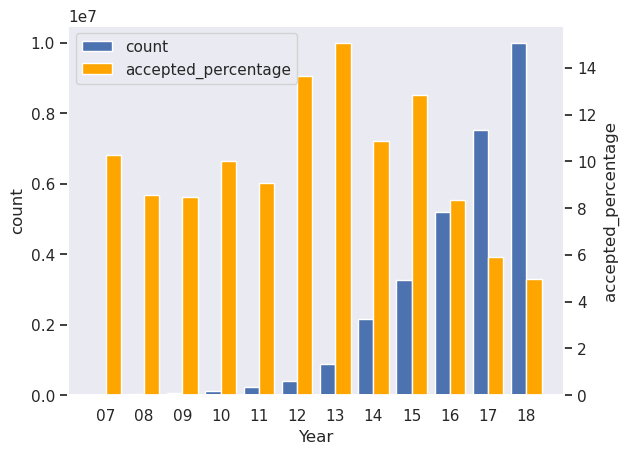

In [27]:
fig_apps_year, ax_apps_year = pf.plot_grouped_bars(
    applications_by_year,
    "year",
    col1="count",
    col2="accepted_percentage",
    legend_args={"loc": "upper left"},
    return_fig=True,
)
ax_apps_year[0].set_xticklabels(text.get_text()[-2:] for text in ax_apps_year[0].xaxis.get_ticklabels())
ax_apps_year[0].set_xlabel('Year')
plt.show()

### Numeric Feature Overview

##### List of numeric features:

In [28]:
numeric_features_ar=["Amount Requested", "Debt-To-Income Ratio"]

#### Visualizing the distribution of numeric features amongst accepted and rejected applications:

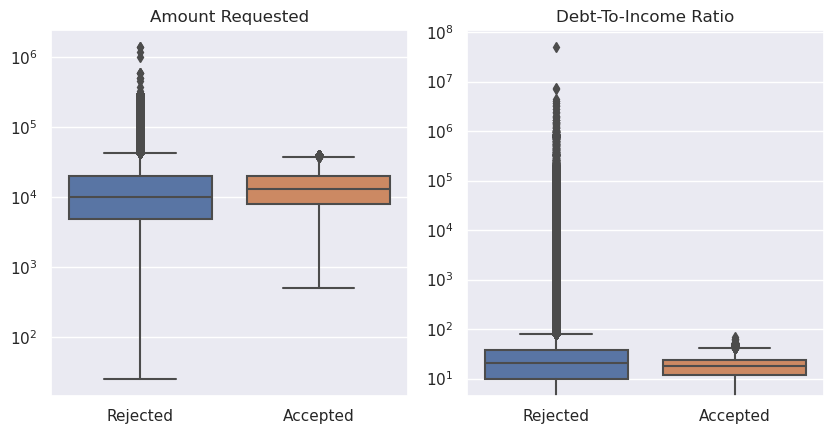

In [29]:
fig_ar_boxes, ax_ar_boxes = plt.subplots(
    1, 2, figsize=BASE_FIG_SIZE
)
ax_ar_boxes = ax_ar_boxes.flatten()
for i, feature in enumerate(numeric_features_ar):
    sns.boxplot(
        x=data_full.select([feature,'Policy Code']).drop_nulls()['Policy Code'].to_numpy(),
        y=data_full.select([feature,'Policy Code']).drop_nulls()[feature].to_numpy(),
        ax=ax_ar_boxes[i],
    )
    ax_ar_boxes[i].set_title(feature)
    ax_ar_boxes[i].set_yscale("log")
    ax_ar_boxes[i].set_xticklabels(["Rejected","Accepted"])
    plt.tight_layout()
plt.show()

#### Mann-Whitney U-test with the hypothesis of no significant differences between populations:

In [30]:
kruskals_ar={}
for col in numeric_features_ar:
    kruskals_ar[col]=st.kruskal_polars(data_full,'Policy Code',col)
    display(Markdown(kruskals_ar[col]['message']))

Reject the null hypothesis: There are significant differences in 'Amount Requested' between groups in 'Policy Code'.

Reject the null hypothesis: There are significant differences in 'Debt-To-Income Ratio' between groups in 'Policy Code'.

### Categorical Feature Overview

In [31]:
cat_features_ar=['month','title','Employment Length','Zip Code','State']

##### Adding the month of the year as a feature:

In [32]:
data_full=data_full.with_columns(pl.col("Application Date").dt.month().alias('month'))

#### Month

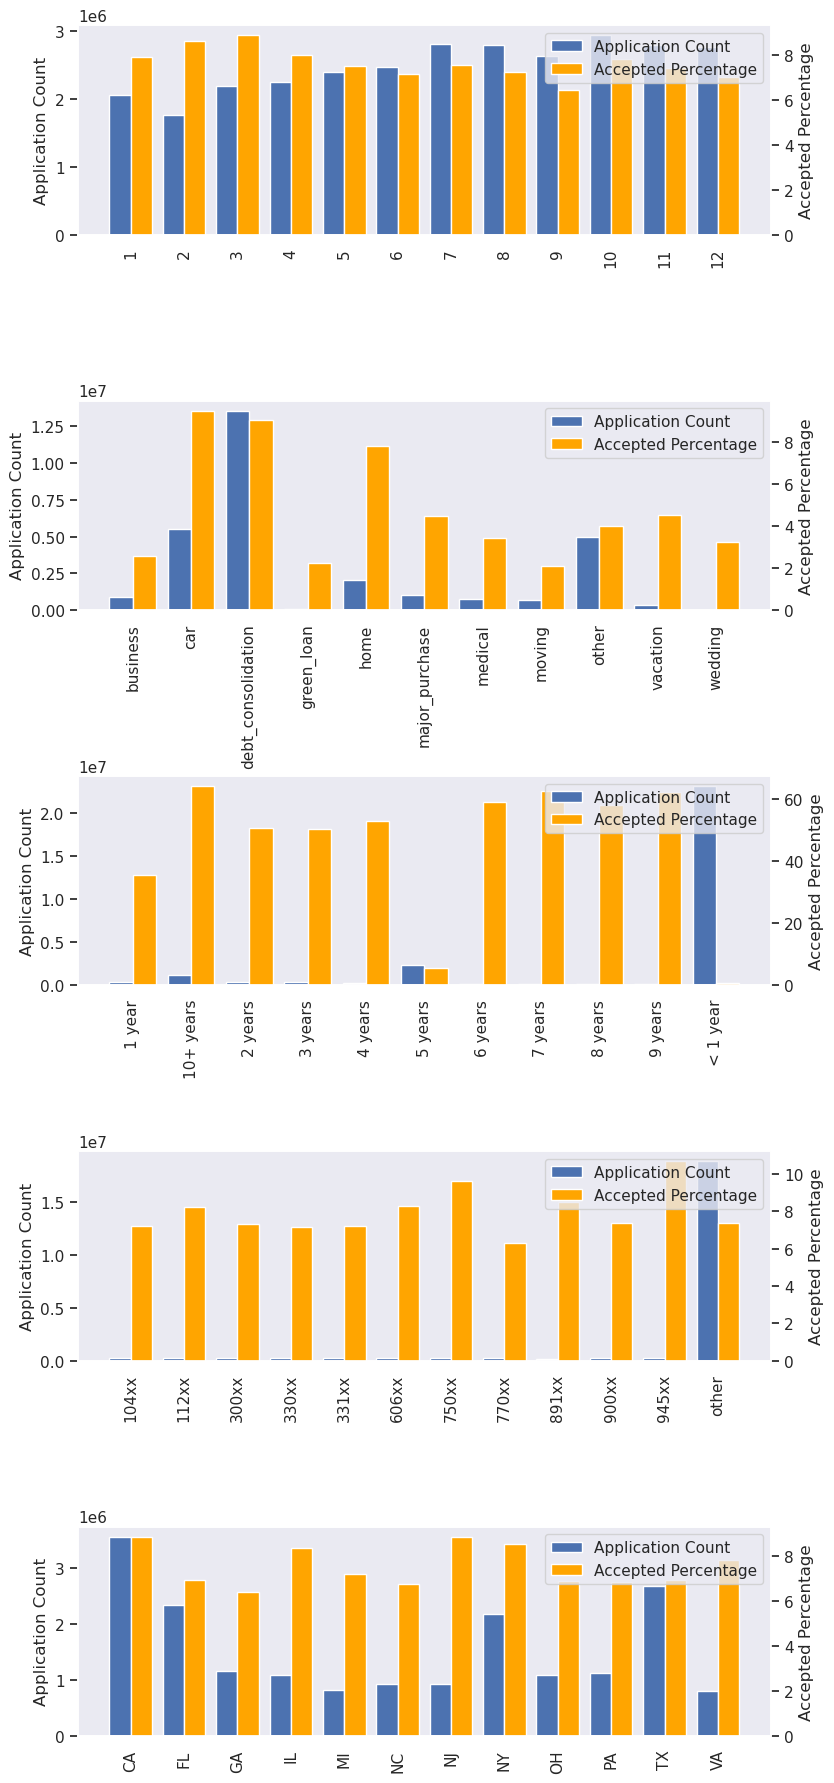

In [33]:
fig_ar_catbars, ax_ar_catbars = plt.subplots(
    5, 1, figsize=(BASE_FIG_SIZE[0], BASE_FIG_SIZE[1]*4)
)
ax_ar_catbars = ax_ar_catbars.flatten()
ax_ar_catbars_b = ax_ar_catbars.copy()
for i, col in enumerate(cat_features_ar):
    ax_ar_catbars_b[i] = ax_ar_catbars[i].twinx()
    pf.plot_grouped_bars(
        pf.aggregate_by_column(
            data_full.drop_nulls(subset="Application Date"),
            col,
            "Policy Code",
            alias_count="Application Count",
            alias_percentage="Accepted Percentage",
            alias_positive_count="Accepted Count",
        ),
        col,
        col1="Application Count",
        col2="Accepted Percentage",
        x_label_args={"rotation": 90},
        legend_args={"loc": "upper right"},
        top_vals=12,
        axes=(ax_ar_catbars[i], ax_ar_catbars_b[i]),
    )
# plt.delaxes(ax_ar_catbars[-1])
plt.tight_layout(h_pad=-0.5)
plt.show()

#### Chi-squared test with the null hypothesis of no significant differences between categories and application approval rate:

In [34]:
ar_chi2s={}
for col in cat_features_ar:
    ar_chi2s[col]=st.chi_squared_polars(data_full,col,'Policy Code')
    display(Markdown(ar_chi2s[col]['message']))


Reject the null hypothesis: There are significant differences in 'Policy Code' between groups in 'month'.

Reject the null hypothesis: There are significant differences in 'Policy Code' between groups in 'title'.

Reject the null hypothesis: There are significant differences in 'Policy Code' between groups in 'Employment Length'.

Reject the null hypothesis: There are significant differences in 'Policy Code' between groups in 'Zip Code'.

Reject the null hypothesis: There are significant differences in 'Policy Code' between groups in 'State'.

### Splits

## Grades

In [35]:
del data_rejected, data_full

In [36]:
data_accepted.head()

id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,…,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
str,str,f64,f64,f64,str,f64,f64,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,f64
"""68407277""",null,3600.0,3600.0,3600.0,""" 36 months""",13.99,123.03,"""C""","""C4""","""leadman""","""10+ years""","""MORTGAGE""",55000.0,"""Not Verified""","""Dec-2015""","""Fully Paid""","""n""","""https://lendin…",null,"""debt_consolida…","""Debt consolida…","""190xx""","""PA""",5.91,0.0,"""Aug-2003""",675.0,679.0,1.0,30.0,null,7.0,0.0,2765.0,29.7,13.0,…,13734.0,null,null,null,null,null,null,null,null,null,null,null,null,null,"""N""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Cash""","""N""",null,null,null,null,null,null
"""68355089""",null,24700.0,24700.0,24700.0,""" 36 months""",11.99,820.28,"""C""","""C1""","""Engineer""","""10+ years""","""MORTGAGE""",65000.0,"""Not Verified""","""Dec-2015""","""Fully Paid""","""n""","""https://lendin…",null,"""small_business…","""Business""","""577xx""","""SD""",16.06,1.0,"""Dec-1999""",715.0,719.0,4.0,6.0,null,22.0,0.0,21470.0,19.2,38.0,…,24667.0,null,null,null,null,null,null,null,null,null,null,null,null,null,"""N""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Cash""","""N""",null,null,null,null,null,null
"""68341763""",null,20000.0,20000.0,20000.0,""" 60 months""",10.78,432.66,"""B""","""B4""","""truck driver""","""10+ years""","""MORTGAGE""",63000.0,"""Not Verified""","""Dec-2015""","""Fully Paid""","""n""","""https://lendin…",null,"""home_improveme…",null,"""605xx""","""IL""",10.78,0.0,"""Aug-2000""",695.0,699.0,0.0,null,null,6.0,0.0,7869.0,56.2,18.0,…,14877.0,null,null,null,null,null,null,null,null,null,null,null,null,null,"""N""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Cash""","""N""",null,null,null,null,null,null
"""66310712""",null,35000.0,35000.0,35000.0,""" 60 months""",14.85,829.9,"""C""","""C5""","""Information Sy…","""10+ years""","""MORTGAGE""",110000.0,"""Source Verifie…","""Dec-2015""","""Current""","""n""","""https://lendin…",null,"""debt_consolida…","""Debt consolida…","""076xx""","""NJ""",17.06,0.0,"""Sep-2008""",785.0,789.0,0.0,null,null,13.0,0.0,7802.0,11.6,17.0,…,18000.0,null,null,null,null,null,null,null,null,null,null,null,null,null,"""N""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""Cash""","""N""",null,null,null,null,null,null
"""68476807""",null,10400.0,10400.0,10400.0,""" 60 months""",22.45,289.91,"""F""","""F1""","""Contract Speci…","""3 years""","""MORTGAGE""",104433.0,"""Source Verifie…","""Dec-2015""","""Fully Paid""","""n""","""https://lendin…",null,"""m

In [37]:
data_accepted["id"].is_duplicated().any()

False

In [38]:
null_counts_accepted = data_accepted.null_count() / len(data_accepted) * 100

null_counts_accepted=pl.DataFrame({"feature": null_counts_accepted.columns}).with_columns(
    null_counts_accepted.transpose().to_series().alias("missing %")
)
null_counts_accepted.filter(null_counts_accepted['missing %']>=50)

feature,missing %
str,f64
"""member_id""",100.0
"""desc""",94.423462
"""mths_since_las…",51.246003
"""mths_since_las…",84.112837
"""next_pymnt_d""",59.509402
"""mths_since_las…",74.309585
"""annual_inc_joi…",94.660428
"""dti_joint""",94.660605
"""verification_s…",94.880717


In [39]:
drop_list = ["id", "member_id", "desc", "url",'policy_code',"payment_plan_start_date"]  # irrelevant
drop_list.extend(
    [col for col in data_accepted.columns if "hardship" in col]
)  # related to the already given loan and not available for new loans.

drop_list.extend(
    [col for col in data_accepted.columns if "settlement" in col]
)  # related to the already given loan and not available for new loans.

drop_list.extend(
    [
        "deferral_term",
        "loan_status",
        "out_prncp",
        "out_prncp_inv",
        "total_pymnt",
        "total_pymnt_inv",
        "total_rec_prncp",
        "total_rec_int",
        "total_rec_late_fee",
        "recoveries",
        "collection_recovery_fee",
        "last_pymnt_d",
        "last_pymnt_amnt",
        "next_pymnt_d",
        "collections_12_mths_ex_med",
        "tot_coll_amt",
        "orig_projected_additional_accrued_interest",
    ]
)  # Not available during application
drop_list.extend(["title"])  # Duplicated with purpose


In [40]:
data_accepted=data_accepted.drop(columns=drop_list)

In [41]:
data_accepted_joint=data_accepted.filter(data_accepted['application_type']=="Joint App")
data_accepted_single=data_accepted.filter(data_accepted['application_type']=="Individual")
joint_app_features=[col for col in data_accepted.columns if any(substring in col for substring in ['joint','sec_app'])]
data_accepted_single=data_accepted_single.drop(columns=joint_app_features)

### Splits

In [42]:
data_accepted_single_train = data_accepted_single.filter(dmf.str_to_date(data_accepted_single,['issue_d'],"%b-%Y")['issue_d'].dt.year()!=2018)
data_accepted_single_test = data_accepted_single.filter(dmf.str_to_date(data_accepted_single,['issue_d'],"%b-%Y")['issue_d'].dt.year()==2018)

data_accepted_joint_train = data_accepted_joint.filter(dmf.str_to_date(data_accepted_joint,['issue_d'],"%b-%Y")['issue_d'].dt.year()!=2018)
data_accepted_joint_test = data_accepted_joint.filter(dmf.str_to_date(data_accepted_joint,['issue_d'],"%b-%Y")['issue_d'].dt.year()==2018)

In [43]:
data_accepted_single_val,data_accepted_single_test = train_test_split(data_accepted_single_test,
    stratify=data_accepted_single_test["grade"],
    train_size=0.3,
    random_state=1,
)

data_accepted_joint_val,data_accepted_joint_test = train_test_split(data_accepted_joint_test,
    stratify=data_accepted_joint_test["grade"],
    train_size=0.3,
    random_state=1,
)

In [44]:
data_accepted_single_train.write_parquet('data/data_accepted_single_train.parquet')
data_accepted_single_val.write_parquet('data/data_accepted_single_val.parquet')
data_accepted_single_test.write_parquet('data/data_accepted_single_test.parquet')

data_accepted_joint_train.write_parquet('data/data_accepted_joint_train.parquet')
data_accepted_joint_val.write_parquet('data/data_accepted_joint_val.parquet')
data_accepted_joint_test.write_parquet('data/data_accepted_joint_test.parquet')

In [45]:
del (
    data_accepted_single_train,
    data_accepted_single_val,
    data_accepted_single_test,
    data_accepted_joint_train,
    data_accepted_joint_val,
    data_accepted_joint_test,
)

### Cleaning

In [46]:
data_accepted_single.head()

loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,pymnt_plan,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,last_credit_pull_d,last_fico_range_high,last_fico_range_low,mths_since_last_major_derog,application_type,…,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,disbursement_method
f64,f64,f64,str,f64,f64,str,str,str,str,str,f64,str,str,str,str,str,str,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,f64,f64,f64,str,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
3600.0,3600.0,3600.0,""" 36 months""",13.99,123.03,"""C""","""C4""","""leadman""","""10+ years""","""MORTGAGE""",55000.0,"""Not Verified""","""Dec-2015""","""n""","""debt_consolida…","""190xx""","""PA""",5.91,0.0,"""Aug-2003""",675.0,679.0,1.0,30.0,null,7.0,0.0,2765.0,29.7,13.0,"""w""","""Mar-2019""",564.0,560.0,30.0,"""Individual""",…,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,"""Cash"""
24700.0,24700.0,24700.0,""" 36 months""",11.99,820.28,"""C""","""C1""","""Engineer""","""10+ years""","""MORTGAGE""",65000.0,"""Not Verified""","""Dec-2015""","""n""","""small_business…","""577xx""","""SD""",16.06,1.0,"""Dec-1999""",715.0,719.0,4.0,6.0,null,22.0,0.0,21470.0,19.2,38.0,"""w""","""Mar-2019""",699.0,695.0,null,"""Individual""",…,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,null,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,"""Cash"""
35000.0,35000.0,35000.0,""" 60 months""",14.85,829.9,"""C""","""C5""","""Information Sy…","""10+ years""","""MORTGAGE""",110000.0,"""Source Verifie…","""Dec-2015""","""n""","""debt_consolida…","""076xx""","""NJ""",17.06,0.0,"""Sep-2008""",785.0,789.0,0.0,null,null,13.0,0.0,7802.0,11.6,17.0,"""w""","""Mar-2019""",679.0,675.0,null,"""Individual""",…,23192.0,54962.0,12.1,0.0,0.0,36.0,87.0,2.0,2.0,1.0,2.0,null,null,null,0.0,4.0,5.0,8.0,10.0,2.0,10.0,13.0,5.0,13.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,381215.0,52226.0,62500.0,18000.0,"""Cash"""
10400.0,10400.0,10400.0,""" 60 months""",22.45,289.91,"""F""","""F1""","""Contract Speci…","""3 years""","""MORTGAGE""",104433.0,"""Source Verifie…","""Dec-2015""","""n""","""major_purchase…","""174xx""","""PA""",25.37,1.0,"""Jun-1998""",695.0,699.0,3.0,12.0,null,12.0,0.0,21929.0,64.5,35.0,"""w""","""Mar-2018""",704.0,700.0,null,"""Individual""",…,27644.0,4567.0,77.5,0.0,0.0,128.0,210.0,4.0,4.0,6.0,4.0,12.0,1.0,12.0,0.0,4.0,6.0,5.0,9.0,10.0,7.0,19.0,6.0,12.0,0.0,0.0,0.0,4.0,96.6,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,"""Cash"""
11950.0,11950.0,11950.0,""" 36 months""",13.44,405.18,"""C""","""C3""","""Veterinary Tec…","""4 years""","""RENT""",34000.0,"""Source Verifie…","""Dec-2015""","""n""","""debt_consolida…","""300xx""","""GA""",10.2,0.0,"""Oct-1987""",690.0,694.0,0.0,null,null,5.0,0.0,8822.0,68.4,6.0,"""w""","""May-2017""",759.0,755.0,null,"""Individual""",…,2560.0,844.0,91.0,0.0,0.0,338.0,54.0,32.0,32.0,0.0,36.0,null,null,null,0.0,2.0,3.0,2.0,2.0,2.0,4.0,4

### Formatting

In [47]:
cols_to_numerize = ["term"]
cols_to_not_in_imput = ["emp_title"]
cols_to_target_encode = ["emp_title"]
cols_to_ordinal_encode = [
    "grade",
    "sub_grade",
    "emp_length",
    "verification_status",
    "verification_status_joint",
    "orig_projected_additional_accrued_interest"
]
calc_len_to_date = ["earliest_cr_line"]
cols_to_label_encode = ["initial_list_status"]

In [48]:
data_accepted_single = dmf.clean_accepted_single(data_accepted_single)
data_accepted_joint = dmf.clean_accepted_joint(data_accepted_joint)

In [49]:
data_accepted_single = data_accepted_single.with_columns(
    tr.NotInImputerPolars(fill_value="other", cat_no=50).fit_transform(data_accepted_single["emp_title"].alias("emp_title"))
)

data_accepted_single = data_accepted_single.with_columns(
    tr.NotInImputerPolars(fill_value="other", cat_no=50).fit_transform(data_accepted_single["zip_code"].alias("zip_code"))
)

data_accepted_joint = data_accepted_joint.with_columns(
    tr.NotInImputerPolars(fill_value="other", cat_no=50).fit_transform(data_accepted_joint["emp_title"].alias("emp_title"))
)

data_accepted_joint = data_accepted_joint.with_columns(
    tr.NotInImputerPolars(fill_value="other", cat_no=50).fit_transform(data_accepted_joint["zip_code"].alias("zip_code"))
)

### Target

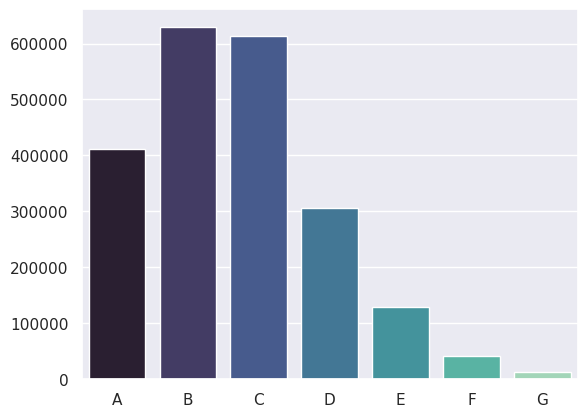

In [50]:
grade_counts=data_accepted_single['grade'].value_counts().sort('grade')
sns.barplot(x=grade_counts['grade'].to_numpy(),y=grade_counts['counts'].to_numpy(),palette='mako')
plt.show()

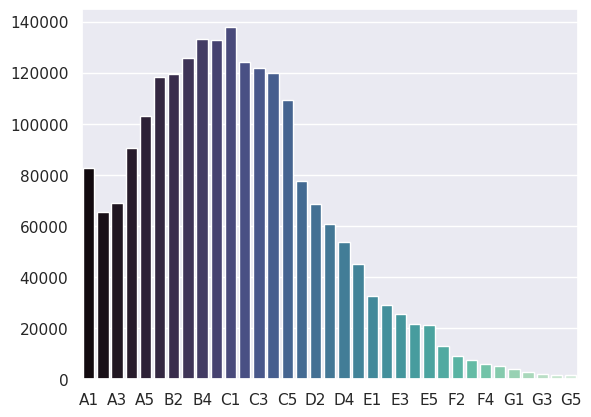

In [51]:
sub_grade_counts=data_accepted_single['sub_grade'].value_counts().sort('sub_grade')
sns.barplot(x=sub_grade_counts['sub_grade'].to_numpy(),y=sub_grade_counts['counts'].to_numpy(),palette='mako')
plt.xticks(np.arange(0,len(sub_grade_counts),step=2))
plt.show()

### num v cat

In [58]:
target_features = ["grade", "sub_grade", "int_rate"]
cat_features_single = []
for col in data_accepted_single.columns:
    if data_accepted_single[col].n_unique() < 1000:
        cat_features_single.append(col)
        
num_features_single = [
    col
    for col in data_accepted_single.columns
    if col not in (cat_features_single +target_features)
]


cat_features_joint = []
for col in data_accepted_joint.columns:
    if data_accepted_joint[col].n_unique() < 900:
        cat_features_joint.append(col)
num_features_joint = [
    col for col in data_accepted_joint.columns if col not in cat_features_joint
]

cat_features_single = [
    feat for feat in cat_features_single if feat not in target_features
]
cat_features_joint = [
    feat for feat in cat_features_joint if feat not in target_features
]
cat_features_joint.remove("issue_d")

In [59]:
len(num_features_single)

20

In [60]:
data_accepted_single[num_features_single].describe()

describe,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,revol_bal,revol_util,tot_cur_bal,total_bal_il,max_bal_bc,total_rev_hi_lim,avg_cur_bal,bc_open_to_buy,bc_util,delinq_amnt,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",2.139958e6,2.139958e6,2.139958e6,2.139958e6,2.139958e6,2.139958e6,2.139958e6,2.139958e6,2.139958e6,2.139958e6,2.139958e6,2.139958e6,2.139958e6,2.139958e6,2.139958e6,2.139958e6,2.139958e6,2.139958e6,2.139958e6,2.139958e6
"""null_count""",0.0,0.0,0.0,0.0,4.0,1.0,0.0,1552.0,70276.0,865781.0,865781.0,70276.0,70336.0,72045.0,73118.0,29.0,70276.0,50030.0,50030.0,70276.0
"""mean""",14788.275564,14782.715958,14763.712471,439.316137,79001.083409,18.093173,16659.488536,50.515903,140391.530112,35170.934794,5795.14961,34474.070395,13282.486287,11313.729005,58.120993,12.80829,175742.685667,50734.088904,23157.266146,43287.474086
"""std""",9035.817271,9033.689041,9037.529629,263.381994,115076.357666,8.4254,22975.955221,24.624473,159957.790505,44151.152535,5688.447941,36714.385633,16250.222784,16510.701202,28.454823,741.254235,180907.813679,49837.616348,22968.96733,44851.098781
"""min""",500.0,500.0,0.0,4.93,1896.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""25%""",8000.0,8000.0,8000.0,249.13,47400.0,11.78,5985.0,31.8,28645.0,8550.0,2301.0,14600.0,3030.0,1716.0,35.8,0.0,49992.0,20796.0,8300.0,14985.0
"""50%""",12250.0,12250.0,12175.0,373.22,65300.0,17.6,11328.0,50.5,76345.0,22761.0,4403.0,25400.0,7101.0,5398.0,60.5,0.0,110983.0,37579.0,16200.0,32300.0
"""75%""",20000.0,20000.0,20000.0,581.69,95000.0,24.04,20209.0,69.5,209472.0,45379.0,7558.0,43000.0,18351.0,14057.0,83.2,0.0,253448.0,63803.0,30200.0,58063.0
"""max""",40000.0,40000.0,40000.0,1719.83,1.1e8,49.96,2.904836e6,892.3,9.971659e6,1.837038e6,1.170668e6,9.999999e6,958084.0,711140.0,339.6,249925.0,9.999999e6,3.408095e6,1.569e6,2.118996e6


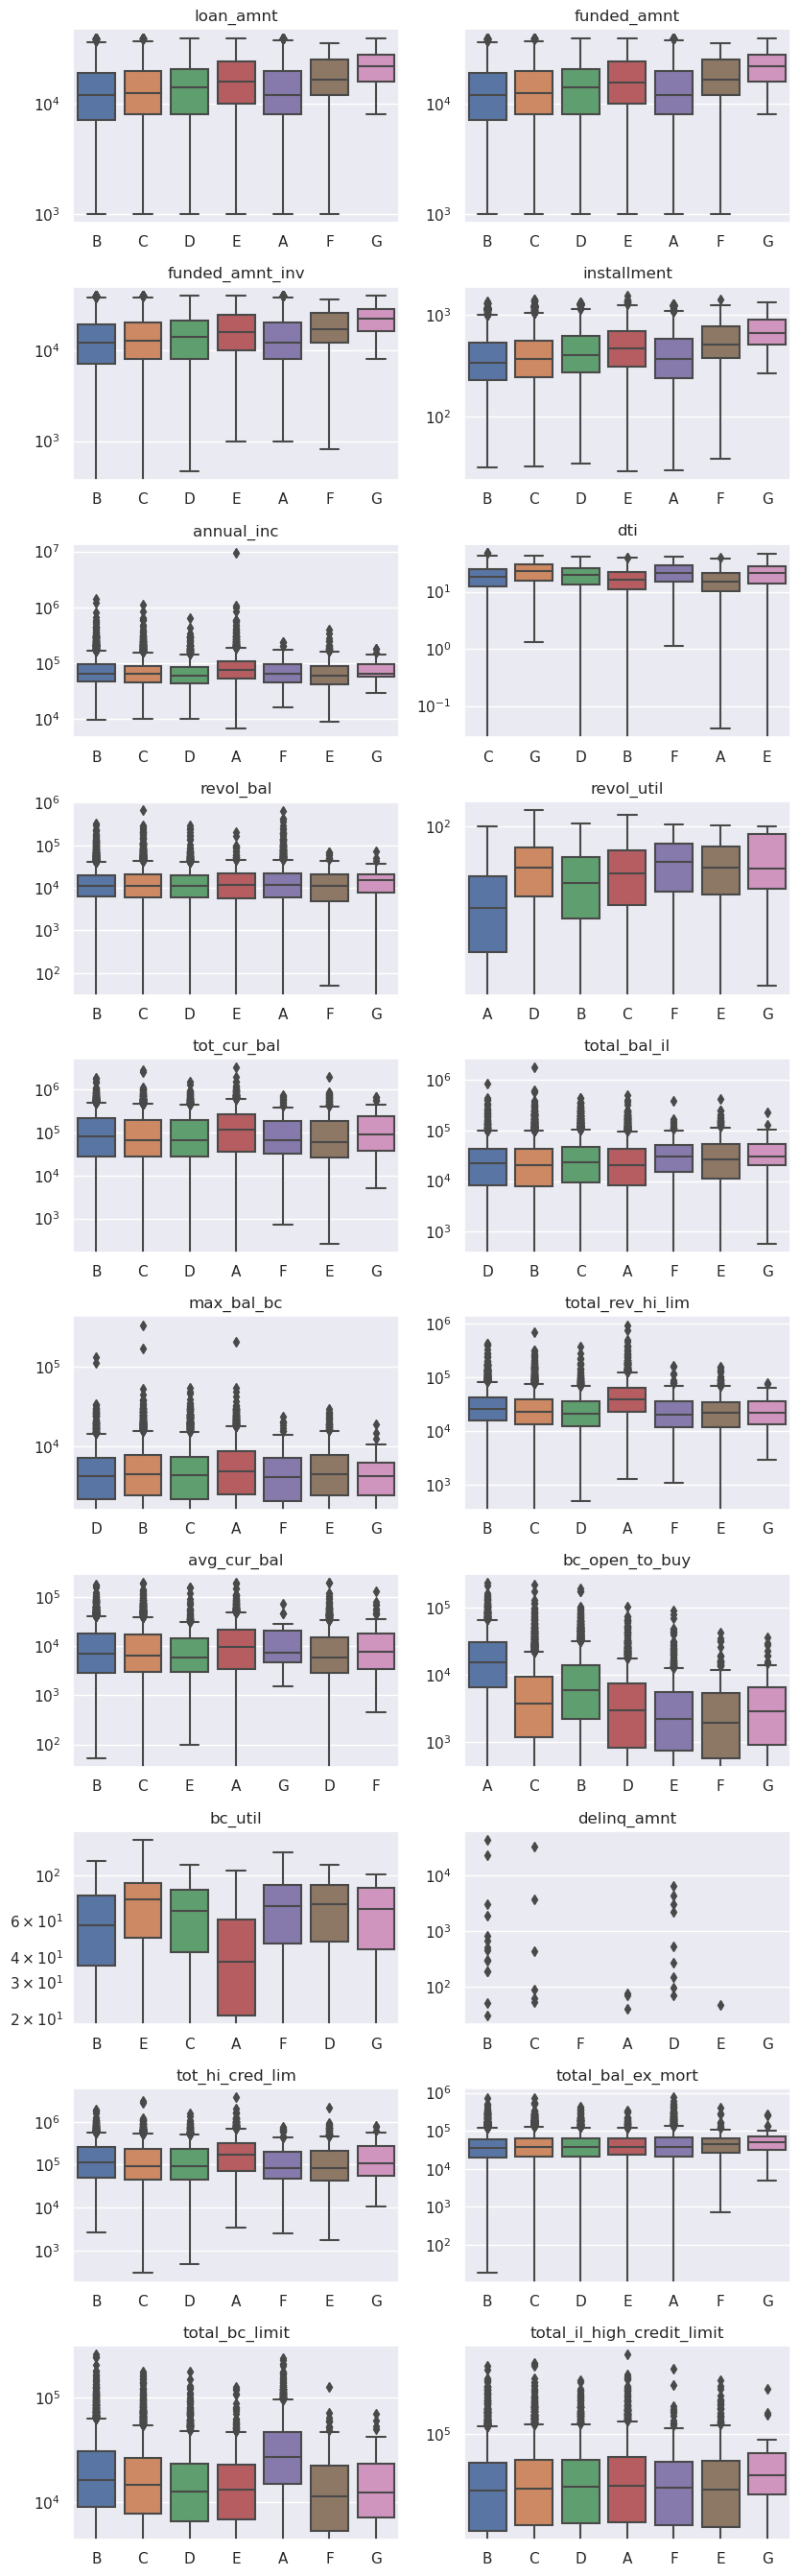

In [61]:
fig_single_boxes, ax_single_boxes = plt.subplots(
    10, 2, figsize=(BASE_FIG_SIZE[0], BASE_FIG_SIZE[1] * 6)
)
ax_single_boxes = ax_single_boxes.flatten()
for i, feature in enumerate(num_features_single):
    sns.boxplot(
        x=data_accepted_single.select([feature,'grade']).drop_nulls().sample(10000, seed=1)['grade'].to_numpy(),
        y=data_accepted_single.select([feature,'grade']).drop_nulls().sample(10000, seed=1)[feature].to_numpy(),
        ax=ax_single_boxes[i],
    )
    ax_single_boxes[i].set_title(feature)
    ax_single_boxes[i].set_yscale("log")
    plt.tight_layout()
plt.show()

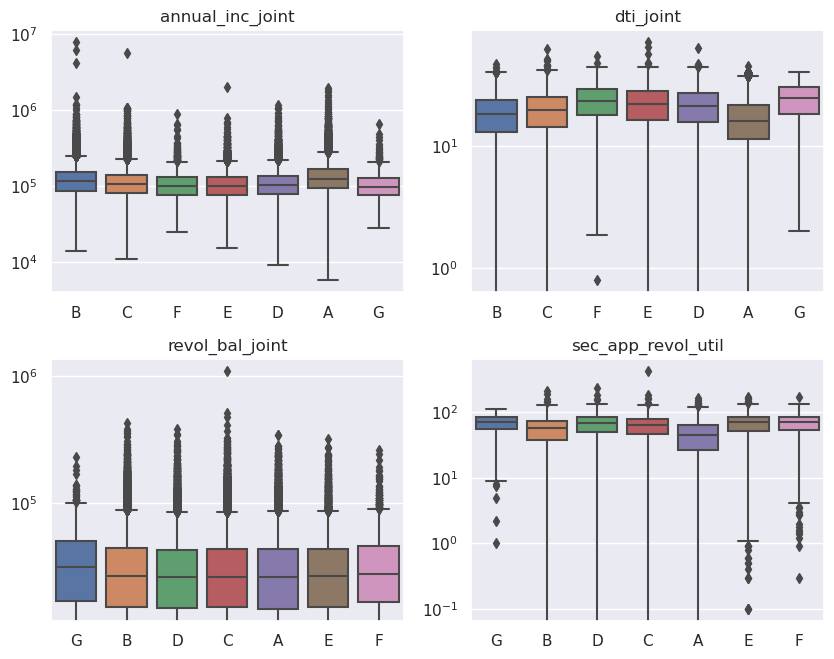

In [62]:
fig_single_boxes_jt, ax_single_boxes_jt = plt.subplots(
    2, 2, figsize=(BASE_FIG_SIZE[0], BASE_FIG_SIZE[1] * 1.5)
)
ax_single_boxes_jt = ax_single_boxes_jt.flatten()
for i, feature in enumerate([i for i in num_features_joint if i not in num_features_single]):
    sns.boxplot(
        x=data_accepted_joint.select([feature,'grade']).drop_nulls()['grade'].to_numpy(),
        y=data_accepted_joint.select([feature,'grade']).drop_nulls()[feature].to_numpy(),
        ax=ax_single_boxes_jt[i],
    )
    ax_single_boxes_jt[i].set_title(feature)
    ax_single_boxes_jt[i].set_yscale("log")
    plt.tight_layout()
plt.show()

In [63]:
kruskals_single={}
for feature in num_features_single:
    kruskals_single[feature]=st.kruskal_polars(data_accepted_single,'grade',feature,alpha=ALPHA)
    display(Markdown(kruskals_single[feature]['message']))


Reject the null hypothesis: There are significant differences in 'loan_amnt' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'funded_amnt' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'funded_amnt_inv' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'installment' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'annual_inc' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'dti' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'revol_bal' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'revol_util' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'tot_cur_bal' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'total_bal_il' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'max_bal_bc' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'total_rev_hi_lim' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'avg_cur_bal' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'bc_open_to_buy' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'bc_util' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'delinq_amnt' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'tot_hi_cred_lim' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'total_bal_ex_mort' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'total_bc_limit' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'total_il_high_credit_limit' between groups in 'grade'.

In [64]:
kruskals_joint={}
for feature in cat_features_joint:
    kruskals_joint[feature]=st.kruskal_polars(data_accepted_joint,'grade',feature,alpha=ALPHA)
    display(Markdown(kruskals_joint[feature]['message']))


Reject the null hypothesis: There are significant differences in 'term' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'emp_title' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'emp_length' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'home_ownership' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'verification_status' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'pymnt_plan' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'purpose' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'zip_code' between groups in 'grade'.

Fail to reject the null hypothesis: There are no significant differences in 'addr_state' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'delinq_2yrs' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'earliest_cr_line' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'fico_range_low' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'fico_range_high' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'inq_last_6mths' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'mths_since_last_delinq' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'mths_since_last_record' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'open_acc' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'pub_rec' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'total_acc' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'initial_list_status' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'last_credit_pull_d' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'last_fico_range_high' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'last_fico_range_low' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'mths_since_last_major_derog' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'verification_status_joint' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'acc_now_delinq' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'open_acc_6m' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'open_act_il' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'open_il_12m' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'open_il_24m' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'mths_since_rcnt_il' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'il_util' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'open_rv_12m' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'open_rv_24m' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'all_util' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'inq_fi' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'total_cu_tl' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'inq_last_12m' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'acc_open_past_24mths' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'chargeoff_within_12_mths' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'delinq_amnt' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'mo_sin_old_il_acct' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'mo_sin_old_rev_tl_op' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'mo_sin_rcnt_rev_tl_op' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'mo_sin_rcnt_tl' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'mort_acc' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'mths_since_recent_bc' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'mths_since_recent_bc_dlq' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'mths_since_recent_inq' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'mths_since_recent_revol_delinq' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'num_accts_ever_120_pd' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'num_actv_bc_tl' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'num_actv_rev_tl' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'num_bc_sats' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'num_bc_tl' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'num_il_tl' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'num_op_rev_tl' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'num_rev_accts' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'num_rev_tl_bal_gt_0' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'num_sats' between groups in 'grade'.

Fail to reject the null hypothesis: There are no significant differences in 'num_tl_120dpd_2m' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'num_tl_30dpd' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'num_tl_90g_dpd_24m' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'num_tl_op_past_12m' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'pct_tl_nvr_dlq' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'percent_bc_gt_75' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'pub_rec_bankruptcies' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'tax_liens' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'sec_app_fico_range_low' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'sec_app_fico_range_high' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'sec_app_earliest_cr_line' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'sec_app_inq_last_6mths' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'sec_app_mort_acc' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'sec_app_open_acc' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'sec_app_open_act_il' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'sec_app_num_rev_accts' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'sec_app_chargeoff_within_12_mths' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'sec_app_collections_12_mths_ex_med' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'sec_app_mths_since_last_major_derog' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'disbursement_method' between groups in 'grade'.

### Categoricals

In [65]:
cat_features_single_low=[]
for col in data_accepted_single.columns:
    if data_accepted_single[col].n_unique()<20:
        cat_features_single_low.append(col)
cat_features_single_low.remove('grade')
# cat_features_single_low.remove('sub_grade')

In [66]:
len(cat_features_single_low)

13

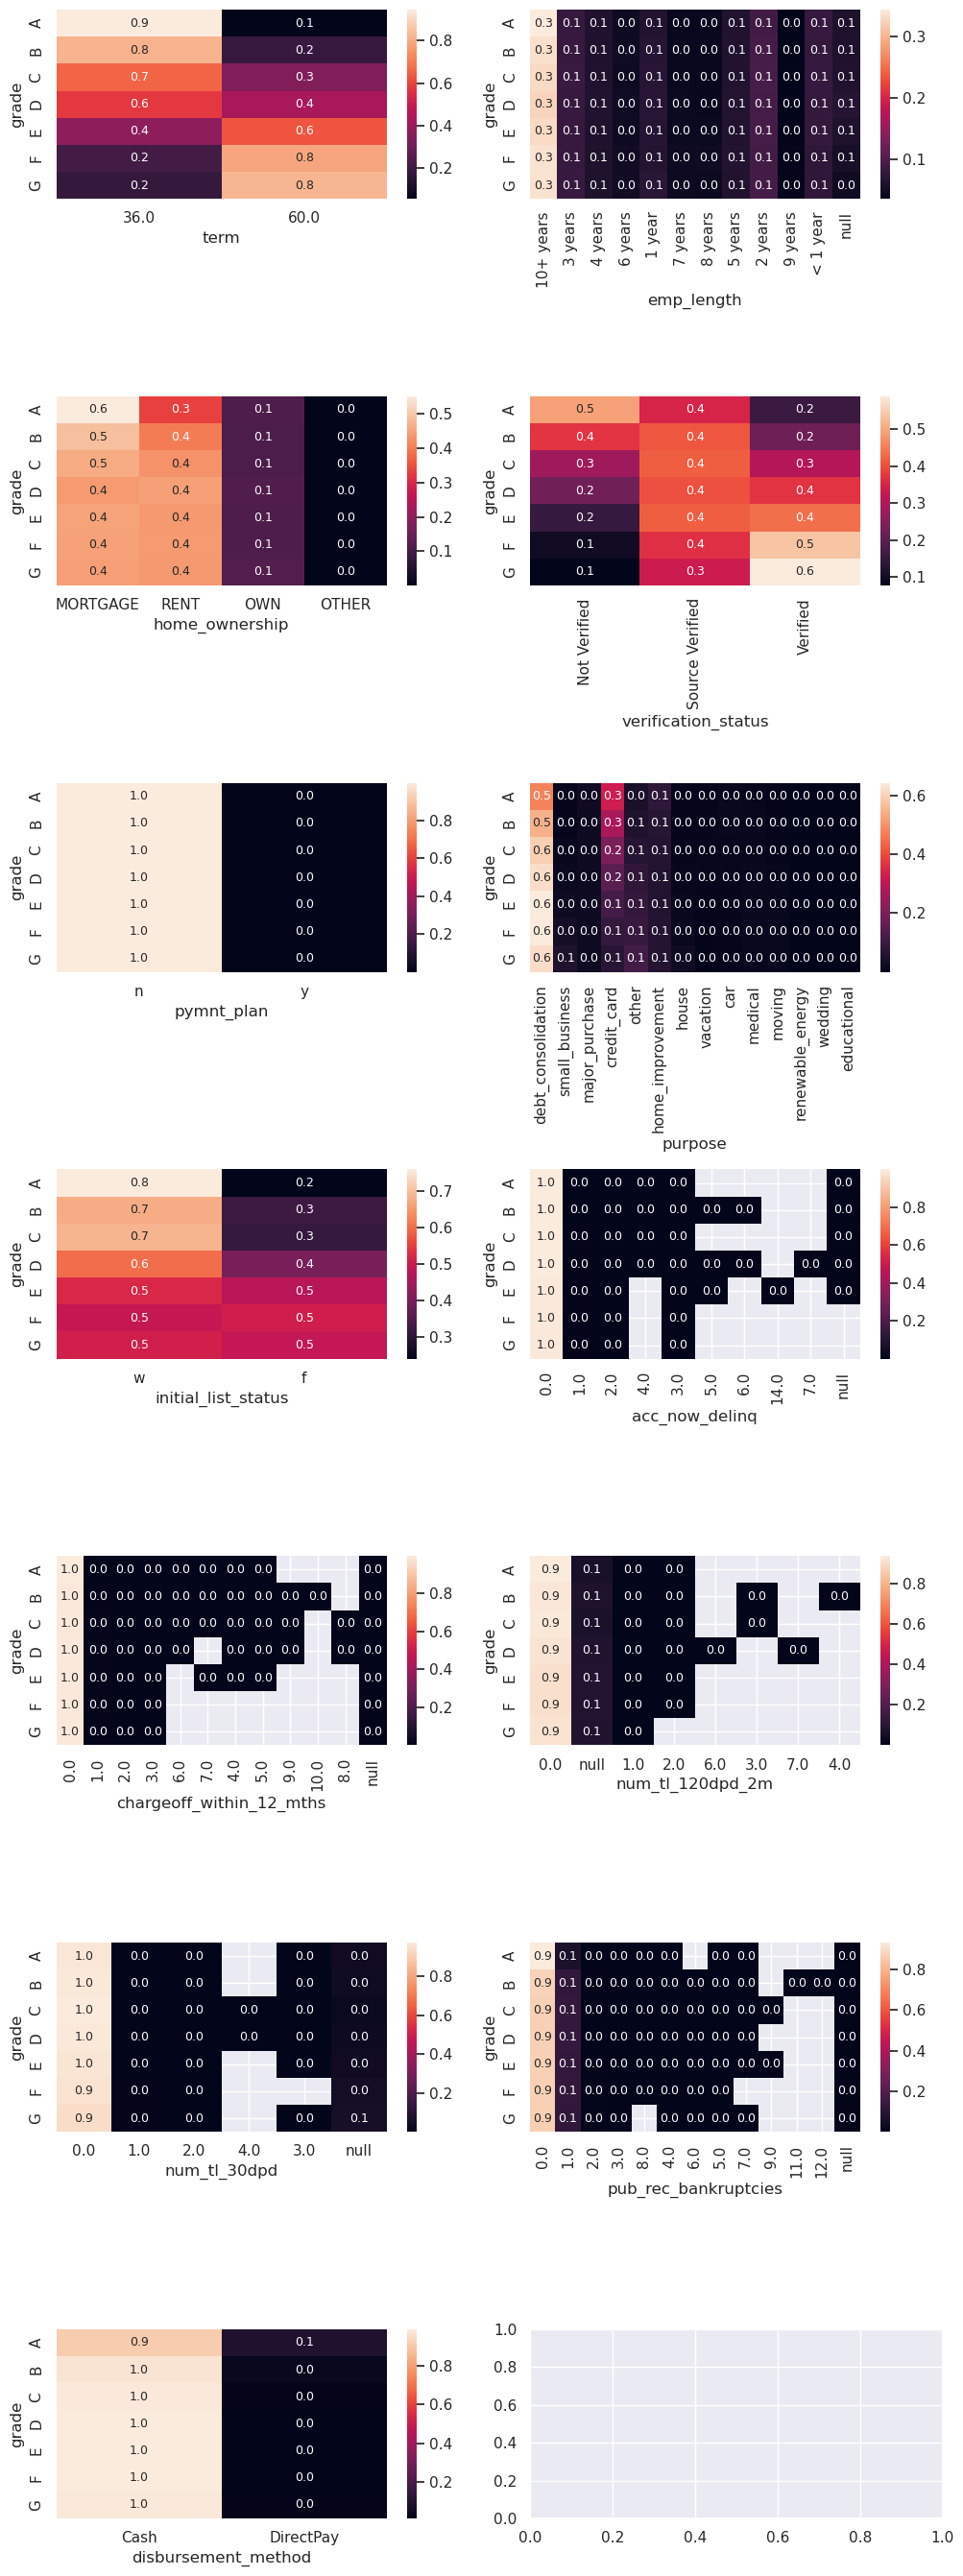

In [67]:
fig_cats,ax_cats=plt.subplots(7,2,figsize=(BASE_FIG_SIZE[0]*1.2,BASE_FIG_SIZE[1]*6))
ax_cats=ax_cats.flatten()
for i, feature in enumerate(cat_features_single_low):
    pf.create_heatmap(data_accepted_single,'grade', feature,ax=ax_cats[i],annot=True, fmt=".1f",annot_kws={"fontsize":9})
plt.delaxes(ax_cats[-1])
plt.tight_layout()
plt.show()

chi

In [68]:
cat_chi2s={}
for col in cat_features_single:
    cat_chi2s[col]=st.chi_squared_polars(data_accepted_single,'grade',col,alpha=ALPHA)
    display(Markdown(cat_chi2s[col]['message']))

Reject the null hypothesis: There are significant differences in 'term' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'emp_title' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'emp_length' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'home_ownership' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'verification_status' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'issue_d' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'pymnt_plan' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'purpose' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'zip_code' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'addr_state' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'delinq_2yrs' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'earliest_cr_line' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'fico_range_low' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'fico_range_high' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'inq_last_6mths' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'mths_since_last_delinq' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'mths_since_last_record' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'open_acc' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'pub_rec' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'total_acc' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'initial_list_status' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'last_credit_pull_d' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'last_fico_range_high' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'last_fico_range_low' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'mths_since_last_major_derog' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'acc_now_delinq' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'open_acc_6m' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'open_act_il' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'open_il_12m' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'open_il_24m' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'mths_since_rcnt_il' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'il_util' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'open_rv_12m' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'open_rv_24m' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'all_util' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'inq_fi' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'total_cu_tl' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'inq_last_12m' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'acc_open_past_24mths' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'chargeoff_within_12_mths' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'mo_sin_old_il_acct' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'mo_sin_old_rev_tl_op' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'mo_sin_rcnt_rev_tl_op' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'mo_sin_rcnt_tl' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'mort_acc' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'mths_since_recent_bc' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'mths_since_recent_bc_dlq' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'mths_since_recent_inq' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'mths_since_recent_revol_delinq' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'num_accts_ever_120_pd' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'num_actv_bc_tl' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'num_actv_rev_tl' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'num_bc_sats' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'num_bc_tl' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'num_il_tl' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'num_op_rev_tl' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'num_rev_accts' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'num_rev_tl_bal_gt_0' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'num_sats' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'num_tl_120dpd_2m' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'num_tl_30dpd' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'num_tl_90g_dpd_24m' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'num_tl_op_past_12m' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'pct_tl_nvr_dlq' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'percent_bc_gt_75' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'pub_rec_bankruptcies' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'tax_liens' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'disbursement_method' between groups in 'grade'.

In [69]:
cat_chi2s_jt={}
for col in cat_features_joint:
    cat_chi2s_jt[col]=st.chi_squared_polars(data_accepted_joint,'grade',col,alpha=ALPHA)
    display(Markdown(cat_chi2s_jt[col]['message']))

Reject the null hypothesis: There are significant differences in 'term' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'emp_title' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'emp_length' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'home_ownership' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'verification_status' between groups in 'grade'.

Fail to reject the null hypothesis: There are no significant differences in 'pymnt_plan' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'purpose' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'zip_code' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'addr_state' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'delinq_2yrs' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'earliest_cr_line' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'fico_range_low' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'fico_range_high' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'inq_last_6mths' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'mths_since_last_delinq' between groups in 'grade'.

Fail to reject the null hypothesis: There are no significant differences in 'mths_since_last_record' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'open_acc' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'pub_rec' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'total_acc' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'initial_list_status' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'last_credit_pull_d' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'last_fico_range_high' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'last_fico_range_low' between groups in 'grade'.

Fail to reject the null hypothesis: There are no significant differences in 'mths_since_last_major_derog' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'verification_status_joint' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'acc_now_delinq' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'open_acc_6m' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'open_act_il' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'open_il_12m' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'open_il_24m' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'mths_since_rcnt_il' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'il_util' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'open_rv_12m' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'open_rv_24m' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'all_util' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'inq_fi' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'total_cu_tl' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'inq_last_12m' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'acc_open_past_24mths' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'chargeoff_within_12_mths' between groups in 'grade'.

Fail to reject the null hypothesis: There are no significant differences in 'delinq_amnt' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'mo_sin_old_il_acct' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'mo_sin_old_rev_tl_op' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'mo_sin_rcnt_rev_tl_op' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'mo_sin_rcnt_tl' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'mort_acc' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'mths_since_recent_bc' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'mths_since_recent_bc_dlq' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'mths_since_recent_inq' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'mths_since_recent_revol_delinq' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'num_accts_ever_120_pd' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'num_actv_bc_tl' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'num_actv_rev_tl' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'num_bc_sats' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'num_bc_tl' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'num_il_tl' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'num_op_rev_tl' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'num_rev_accts' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'num_rev_tl_bal_gt_0' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'num_sats' between groups in 'grade'.

Fail to reject the null hypothesis: There are no significant differences in 'num_tl_120dpd_2m' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'num_tl_30dpd' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'num_tl_90g_dpd_24m' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'num_tl_op_past_12m' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'pct_tl_nvr_dlq' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'percent_bc_gt_75' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'pub_rec_bankruptcies' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'tax_liens' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'sec_app_fico_range_low' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'sec_app_fico_range_high' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'sec_app_earliest_cr_line' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'sec_app_inq_last_6mths' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'sec_app_mort_acc' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'sec_app_open_acc' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'sec_app_open_act_il' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'sec_app_num_rev_accts' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'sec_app_chargeoff_within_12_mths' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'sec_app_collections_12_mths_ex_med' between groups in 'grade'.

Reject the null hypothesis: There are significant differences in 'sec_app_mths_since_last_major_derog' between groups in 'grade'.

Fail to reject the null hypothesis: There are no significant differences in 'disbursement_method' between groups in 'grade'.

### Correlating Features

In [70]:
vif=st.calc_vif(data_accepted_single[num_features_single].drop_nulls())
vif

variables,VIF
str,f64
"""funded_amnt""",2.6916e6
"""loan_amnt""",2.3775e6
"""funded_amnt_in…",313697.557863
"""total_bal_ex_m…",96.845412
"""total_bal_il""",79.043741
"""tot_hi_cred_li…",70.075859
"""tot_cur_bal""",64.660449
"""total_rev_hi_l…",37.431626
"""installment""",35.813364


In [71]:
correlating_to_drop=['funded_amnt','funded_amnt_inv','total_bal_ex_mort','tot_hi_cred_lim']

In [72]:
vif=st.calc_vif(data_accepted_single[num_features_single].drop(columns=correlating_to_drop).drop_nulls())
vif

variables,VIF
str,f64
"""loan_amnt""",36.193204
"""installment""",35.531733
"""total_rev_hi_l…",34.448362
"""total_bc_limit…",26.287153
"""total_il_high_…",25.932684
"""revol_util""",24.641274
"""bc_util""",22.792979
"""total_bal_il""",19.32747
"""bc_open_to_buy…",18.836208


In [73]:
vif_joint=st.calc_vif(data_accepted_joint[num_features_joint].drop(columns=correlating_to_drop).drop_nulls())
vif_joint

variables,VIF
str,f64
"""total_bc_limit…",39.656989
"""loan_amnt""",31.599124
"""installment""",30.667513
"""total_il_high_…",29.043934
"""bc_open_to_buy…",27.591667
"""revol_util""",22.966219
"""total_bal_il""",22.01619
"""total_rev_hi_l…",20.552117
"""bc_util""",20.543986
